In [1]:
from pickle import load, dump, HIGHEST_PROTOCOL

In [2]:
from glob import glob
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import os
import pandas as pd

In [4]:
rpath = '../../data/ComplementaryData/HiC/TADbit_results/'

In [5]:
times = ['0h', '1h', '4h', '7h', '10h', '24h', 'w24h']

## Load TAD borders

In [43]:
tads = {}
for time in times:
    li = []
    lpath = glob(os.path.join(rpath, f'Cabrera_2022_HCT116_WT_*_{time}', '06_segmentation', 'tads_50kb'))
    if len(lpath) > 1:
        raise Exception(lpath)
    lpath = lpath[0]
    for fnam in os.listdir(lpath):
        chrom = fnam.split('_')[0]
        data = pd.read_csv(os.path.join(lpath, fnam), sep='\t', 
                           skiprows=1, skipfooter=1, engine='python', usecols=[2, 3, 4],
                           names=[f"pos_{time}", f"score_{time}", f"density_{time}"], 
                        dtype={
                            f"pos_{time}":      'int',
                            f"score_{time}":    'float',
                            f"density_{time}":    'float',
                            f"Chromosome":     'object'
                              })
        data['Chromosome'] = [chrom] * len(data)
        li.append(data)
        tads[time] = pd.concat(li, axis=0, ignore_index=True).sort_values(by=f"pos_{time}")

In [44]:
tads['w24h']

,pos_w24h,score_w24h,density_w24h,Chromosome
719,3,7.0,1.345,chr2
980,4,10.0,0.109,chr12
2215,4,9.0,0.884,chr10
1801,4,7.0,3.851,chr7
2035,5,7.0,0.245,chr6
...,...,...,...,...
1693,4940,5.0,1.011,chr1
1694,4949,8.0,1.218,chr1
1695,4954,8.0,0.924,chr1
1696,4973,10.0,1.277,chr1


## Align TAD borders

In [135]:
def align_TAD_borders(left_tads, right_tads, left_suffix, right_suffix, dist_cut=2):
    """
    Align TAD borders, reading them from a pandas dataframe.
    It uses pandas.merge_asof function to gather the intersection within the 
    defined distance cutoff, and then adds back unaligned borders.
    Aligned border are merged into an average position if they do not match perfectly.

    """
    # convert coordinates to floats
    # left_tads[f"pos_{left_suffix}"] = left_tads[f"pos_{left_suffix}"].astype(float, copy=True)
    left_tads.loc[:,f"pos_{left_suffix}"] = left_tads[f"pos_{left_suffix}"].astype(float, copy=True)
    # right_tads[f"pos_{right_suffix}"] = right_tads[f"pos_{right_suffix}"].astype(float, copy=True)
    right_tads.loc[:,f"pos_{right_suffix}"] = right_tads[f"pos_{right_suffix}"].astype(float, copy=True)
    # store copy
    pre_a = left_tads
    pre_b = right_tads
    # align left with right
    left_merge = pd.merge_asof(pre_a, pre_b, 
                               left_on=f"pos_{left_suffix}", right_on=f"pos_{right_suffix}", 
                               direction='nearest', tolerance=dist_cut, by="Chromosome", suffixes=('', ''))
    # align right with left
    right_merge = pd.merge_asof(pre_b, pre_a,
                                left_on=f"pos_{right_suffix}", right_on=f"pos_{left_suffix}", 
                                direction='nearest', tolerance=dist_cut, by="Chromosome", suffixes=('', ''))
    # take intersection of both alignments
    intersection = pd.merge(left_merge, right_merge, on=list(right_merge.columns), 
                            how='inner')
    # average positions to generate consensus
    tmp_global = np.nanmean([intersection[f"pos_{left_suffix}"],
                                             intersection[f"pos_{right_suffix}"]], axis=0)
    ####
    # add unaligned positions (gaps)
    missing_left = pd.DataFrame()
    for row in left_tads.iterrows():
        row = pd.DataFrame(row[1].to_frame().T)
        res = pd.merge(row[[f'pos_{left_suffix}', 'Chromosome']], 
                       intersection[[f'pos_{left_suffix}', 'Chromosome']])
        if not len(res):
            # missing_left.loc[len(missing_left)] = row  # old pandas version
            missing_left = pd.concat([missing_left, row], ignore_index=True)

    missing_right = pd.DataFrame()
    for row in right_tads.iterrows():
        row = pd.DataFrame(row[1].to_frame().T)
        res = pd.merge(row[[f'pos_{right_suffix}', 'Chromosome']], 
                       intersection[[f'pos_{right_suffix}', 'Chromosome']])
        if not len(res):
            # missing_right = missing_right.append(row)
            missing_right = pd.concat([missing_right, row], ignore_index=True)
    missing_right["pos_global"] = missing_right[f"pos_{right_suffix}"]

    missing_left.reset_index(drop=True)
    missing_right.reset_index(drop=True)
    
    intersection["pos_global"] = tmp_global
    # intersection = intersection.append(missing_left)
    intersection = pd.concat([intersection, missing_left.infer_objects()], ignore_index=True)
    # intersection = intersection.append(missing_right)
    intersection = pd.concat([intersection, missing_right.infer_objects()], ignore_index=True)
    intersection.sort_values(by=f"pos_{left_suffix}", inplace=True)
    intersection.reset_index(inplace=True, drop=True)
    for c in intersection.columns:
        if c.startswith('pos') and c != 'pos_global':
            intersection.loc[np.isnan(intersection[c]), c] = intersection[np.isnan(intersection[c])]['pos_global']
            intersection[c] = intersection[c].astype('int')
    intersection['pos_global'] = intersection['pos_global'].astype('int')
    return intersection, len(left_merge), len(right_merge)

In [128]:
samples = list(tads.keys())

In [49]:
dist_cut = 2
score_cut = 4
for nt1, (time1) in enumerate(times, 1):
    for time2 in times[nt1:]:
        c, a, b = align_TAD_borders(tads[time1][tads[time1][f'score_{time1}'] > score_cut],
                                    tads[time2][tads[time2][f'score_{time2}'] > score_cut], 
                                    f'{time1}', f'{time2}')
        print(f"{time1:4} : {time2:4} => {a:5} {b:5} {len(c[c[[f'pos_{time1}',f'pos_{time2}']].isnull().sum(axis=1) == 0]):5} {len(c) / min(a, b):.2f}")

0h   : 1h   =>  3963  3187  2953 1.32
0h   : 4h   =>  3963  3098  2879 1.35
0h   : 7h   =>  3963  3097  2871 1.35
0h   : 10h  =>  3963  3456  3228 1.21
0h   : 24h  =>  3963  2820  2524 1.51
0h   : w24h =>  3963  3222  2899 1.33
1h   : 4h   =>  3187  3098  2899 1.09
1h   : 7h   =>  3187  3097  2868 1.10
1h   : 10h  =>  3187  3456  2887 1.18
1h   : 24h  =>  3187  2820  2369 1.29
1h   : w24h =>  3187  3222  2839 1.12
4h   : 7h   =>  3098  3097  2893 1.07
4h   : 10h  =>  3098  3456  2837 1.20
4h   : 24h  =>  3098  2820  2341 1.27
4h   : w24h =>  3098  3222  2786 1.14
7h   : 10h  =>  3097  3456  2860 1.19
7h   : 24h  =>  3097  2820  2357 1.26
7h   : w24h =>  3097  3222  2788 1.14
10h  : 24h  =>  3456  2820  2473 1.35
10h  : w24h =>  3456  3222  2872 1.18
24h  : w24h =>  2820  3222  2379 1.30


### Align all vs all

In [134]:
aligned_tads.dtypes

pos_0h          int64
score_0h      float64
density_0h    float64
Chromosome     object
pos_global    float64
pos_1h          int64
score_1h      float64
density_1h    float64
dtype: object

In [137]:
dist_cut = 2
score_cut = 2
time1 = times[0]
aligned_tads = tads[time1][tads[time1][f'score_{time1}'] > score_cut].copy()
aligned_tads['pos_global'] = aligned_tads['pos_0h'].copy()
for nt2, (time2) in enumerate(times[1:], 1):
    aligned_tads, a, b = align_TAD_borders(aligned_tads, tads[time2][tads[time2][f'score_{time2}'] > score_cut], 
                                           'global', f'{time2}')
    print(f"{time1:4} : {time2:4} => {a:5} {b:5} {len(aligned_tads):5} {len(aligned_tads) / min(a, b):.2f}")

0h   : 1h   =>  4152  3353  4338 1.29
0h   : 4h   =>  4338  3235  4383 1.35
0h   : 7h   =>  4383  3185  4425 1.39
0h   : 10h  =>  4425  3572  4526 1.27
0h   : 24h  =>  4526  2963  4725 1.59
0h   : w24h =>  4725  3248  4824 1.49


### check that we get the same number of TADs after alignment

In [138]:
for time in times:
    print(time, len(aligned_tads[(aligned_tads['Chromosome']=='chr22') & 
                           (aligned_tads[f'score_{time}']>score_cut)]),
          len(tads[time][(tads[time]['Chromosome']=='chr22') & (tads[time][f'score_{time}']>score_cut)]))

0h 75 75
1h 60 60
4h 55 55
7h 55 55
10h 63 63
24h 46 46
w24h 63 63


In [24]:
for time in times:
    print(time, len(aligned_tads[(aligned_tads['Chromosome']=='chr2') & 
                           (aligned_tads[f'score_{time}']>score_cut)]),
          len(tads[time][(tads[time]['Chromosome']=='chr2') & (tads[time][f'score_{time}']>score_cut)]))

0h 339 339
1h 272 272
4h 262 262
7h 254 254
10h 278 278
24h 244 244
w24h 261 261
w48h 248 248


### reformat alignment dataframe

In [139]:
aligned_tads = aligned_tads.rename(columns={'pos_global': 'position'})

In [140]:
aligned_tads

,pos_0h,score_0h,density_0h,Chromosome,position,pos_1h,score_1h,density_1h,pos_4h,score_4h,...,density_7h,pos_10h,score_10h,density_10h,pos_24h,score_24h,density_24h,pos_w24h,score_w24h,density_w24h
0,3,10.0,1.479,chr2,3,3,10.0,1.497,3,10.0,...,1.460,3,10.0,1.358,3,10.0,1.582,3,7.0,1.345
1,3,5.0,1.469,chr5,3,3,NaN,NaN,3,NaN,...,NaN,3,NaN,NaN,3,NaN,NaN,3,NaN,NaN
2,5,7.0,0.938,chr7,3,4,7.0,0.600,3,5.0,...,1.696,3,NaN,NaN,3,NaN,NaN,4,7.0,3.851
3,4,5.0,0.926,chr10,4,5,6.0,0.882,4,5.0,...,0.717,4,6.0,0.798,6,7.0,0.294,4,9.0,0.884
4,7,5.0,0.707,chr20,5,5,6.0,0.772,5,6.0,...,0.919,5,5.0,0.953,5,NaN,NaN,5,10.0,1.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4819,4955,10.0,0.883,chr1,4954,4954,8.0,0.801,4954,9.0,...,1.008,4955,10.0,0.875,4954,9.0,0.879,4954,8.0,0.924
4820,4960,3.0,0.989,chr1,4960,4960,NaN,NaN,4960,NaN,...,NaN,4960,NaN,NaN,4960,NaN,NaN,4960,NaN,NaN
4821,4965,3.0,0.948,chr1,4962,4963,5.0,0.934,4964,NaN,...,0.923,4962,6.0,1.017,4962,NaN,NaN,4962,NaN,NaN
4822,4974,6.0,0.963,chr1,4973,4974,6.0,0.932,4974,NaN,...,0.960,4974,7.0,1.070,4973,10.0,1.149,4973,10.0,1.277


In [141]:
aligned_tads['position'] = aligned_tads['position'] * 50_000

In [142]:
aligned_tads['position'] = aligned_tads['position'].astype(int)

In [143]:
aligned_tads

,pos_0h,score_0h,density_0h,Chromosome,position,pos_1h,score_1h,density_1h,pos_4h,score_4h,...,density_7h,pos_10h,score_10h,density_10h,pos_24h,score_24h,density_24h,pos_w24h,score_w24h,density_w24h
0,3,10.0,1.479,chr2,150000,3,10.0,1.497,3,10.0,...,1.460,3,10.0,1.358,3,10.0,1.582,3,7.0,1.345
1,3,5.0,1.469,chr5,150000,3,NaN,NaN,3,NaN,...,NaN,3,NaN,NaN,3,NaN,NaN,3,NaN,NaN
2,5,7.0,0.938,chr7,150000,4,7.0,0.600,3,5.0,...,1.696,3,NaN,NaN,3,NaN,NaN,4,7.0,3.851
3,4,5.0,0.926,chr10,200000,5,6.0,0.882,4,5.0,...,0.717,4,6.0,0.798,6,7.0,0.294,4,9.0,0.884
4,7,5.0,0.707,chr20,250000,5,6.0,0.772,5,6.0,...,0.919,5,5.0,0.953,5,NaN,NaN,5,10.0,1.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4819,4955,10.0,0.883,chr1,247700000,4954,8.0,0.801,4954,9.0,...,1.008,4955,10.0,0.875,4954,9.0,0.879,4954,8.0,0.924
4820,4960,3.0,0.989,chr1,248000000,4960,NaN,NaN,4960,NaN,...,NaN,4960,NaN,NaN,4960,NaN,NaN,4960,NaN,NaN
4821,4965,3.0,0.948,chr1,248100000,4963,5.0,0.934,4964,NaN,...,0.923,4962,6.0,1.017,4962,NaN,NaN,4962,NaN,NaN
4822,4974,6.0,0.963,chr1,248650000,4974,6.0,0.932,4974,NaN,...,0.960,4974,7.0,1.070,4973,10.0,1.149,4973,10.0,1.277


### save Alignment dataframe

In [145]:
aligned_tads = aligned_tads[['Chromosome', 'position',
                             'pos_0h', 'score_0h', 'density_0h',
                             'pos_1h', 'score_1h', 'density_1h',
                             'pos_4h', 'score_4h', 'density_4h',
                             'pos_7h', 'score_7h', 'density_7h',
                             'pos_10h', 'score_10h', 'density_10h',
                             'pos_24h', 'score_24h', 'density_24h',
                             'pos_w24h', 'score_w24h', 'density_w24h',
                            ]]

In [146]:
aligned_tads.to_csv('aligned_TAD_borders.tsv', sep='\t', index=False)

### Load Aligned TAD borders

In [147]:
# aligned_tads = pd.read_csv(open('aligned_TAD_borders.tsv', 'rb'), sep='\t')

#### do some stupid filtering to explore data

In [148]:
score_cut = 2
time = '0h'

In [149]:
aligned_tads[(aligned_tads['Chromosome']=='chr22') 
                         & (aligned_tads[f'pos_{time}'] > 450)
                         &  (aligned_tads[f'score_{time}'] > score_cut)]

,Chromosome,position,pos_0h,score_0h,density_0h,pos_1h,score_1h,density_1h,pos_4h,score_4h,...,density_7h,pos_10h,score_10h,density_10h,pos_24h,score_24h,density_24h,pos_w24h,score_w24h,density_w24h
825,chr22,22650000,454,5.0,0.823,455,8.0,0.991,455,7.0,...,0.976,453,3.0,0.818,452,5.0,0.486,454,6.0,0.821
838,chr22,23300000,466,10.0,0.933,466,5.0,1.111,466,NaN,...,NaN,466,NaN,NaN,466,NaN,NaN,466,5.0,1.096
842,chr22,23400000,471,8.0,1.225,471,5.0,1.243,470,3.0,...,1.102,469,4.0,0.856,468,10.0,0.677,468,NaN,NaN
859,chr22,23850000,478,7.0,0.985,478,3.0,0.970,478,NaN,...,NaN,478,8.0,0.990,478,NaN,NaN,477,5.0,1.023
870,chr22,24250000,484,9.0,0.718,486,7.0,1.125,486,10.0,...,1.061,485,NaN,NaN,485,NaN,NaN,486,10.0,1.518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818,chr22,49350000,988,7.0,0.903,988,9.0,1.179,988,8.0,...,1.179,987,7.0,0.759,987,NaN,NaN,987,5.0,1.432
1840,chr22,49800000,995,9.0,1.021,997,5.0,1.002,994,3.0,...,NaN,995,7.0,1.073,995,NaN,NaN,997,7.0,1.133
1850,chr22,50100000,1002,10.0,1.215,1002,10.0,1.010,1002,10.0,...,1.052,1002,10.0,1.249,1002,10.0,0.255,1002,10.0,1.191
1859,chr22,50350000,1007,4.0,1.278,1007,NaN,NaN,1007,NaN,...,NaN,1007,NaN,NaN,1007,NaN,NaN,1007,NaN,NaN


In [150]:
aligned_tads[(aligned_tads['Chromosome']=='chr22') 
                         & (aligned_tads[f'pos_{time}'] > 450)
                         & (aligned_tads[f'pos_{time}'] < 475)
                         &  (aligned_tads[f'score_{time}'] > score_cut)]

,Chromosome,position,pos_0h,score_0h,density_0h,pos_1h,score_1h,density_1h,pos_4h,score_4h,...,density_7h,pos_10h,score_10h,density_10h,pos_24h,score_24h,density_24h,pos_w24h,score_w24h,density_w24h
825,chr22,22650000,454,5.0,0.823,455,8.0,0.991,455,7.0,...,0.976,453,3.0,0.818,452,5.0,0.486,454,6.0,0.821
838,chr22,23300000,466,10.0,0.933,466,5.0,1.111,466,NaN,...,NaN,466,NaN,NaN,466,NaN,NaN,466,5.0,1.096
842,chr22,23400000,471,8.0,1.225,471,5.0,1.243,470,3.0,...,1.102,469,4.0,0.856,468,10.0,0.677,468,NaN,NaN


In [151]:
tads[time][(tads[time]['Chromosome']=='chr22')
           & (tads[time][f'pos_{time}'] > 450)
           & (tads[time][f'score_{time}'] > score_cut)]

,pos_0h,score_0h,density_0h,Chromosome
1174,454,5.0,0.823,chr22
1175,466,10.0,0.933,chr22
1176,471,8.0,1.225,chr22
1177,478,7.0,0.985,chr22
1178,484,9.0,0.718,chr22
...,...,...,...,...
1233,988,7.0,0.903,chr22
1234,995,9.0,1.021,chr22
1235,1002,10.0,1.215,chr22
1236,1007,4.0,1.278,chr22


In [152]:
len(aligned_tads)

4824

In [153]:
len(tads['0h'])

4155

## view TAD borders

In [154]:
from pytadbit.parsers.genome_parser import parse_fasta

In [155]:
chromosomes = parse_fasta('hg19.fa', only_length=True, chr_regexp='^chr[0-9XY]+$', verbose=False)

In [156]:
chromosomes = dict((C, chromosomes[C]) for C in [f'chr{c}' for c in list(range(1, 23)) + ['X', 'Y']])

In [157]:
chromosomes

{'chr1': 249250621,
 'chr2': 243199373,
 'chr3': 198022430,
 'chr4': 191154276,
 'chr5': 180915260,
 'chr6': 171115067,
 'chr7': 159138663,
 'chr8': 146364022,
 'chr9': 141213431,
 'chr10': 135534747,
 'chr11': 135006516,
 'chr12': 133851895,
 'chr13': 115169878,
 'chr14': 107349540,
 'chr15': 102531392,
 'chr16': 90354753,
 'chr17': 81195210,
 'chr18': 78077248,
 'chr19': 59128983,
 'chr20': 63025520,
 'chr21': 48129895,
 'chr22': 51304566,
 'chrX': 155270560,
 'chrY': 59373566}

In [158]:
chrom = 'chr12'
start = 110_000_000
end   = 130_000_000

In [160]:
borders = aligned_tads[aligned_tads['Chromosome'] == chrom][
    ['position'] + [f'pos_{t}' for t in times] + [f'score_{t}' for t in times]].round(0)

In [161]:
def plot_alignment(chrom, start=None, end=None, resolution=50_000):
    if start is None:
        size = chromosomes[chrom] // resolution
        start = 0
        end = size
    else:
        size = (end - start) // resolution
        start //= resolution
        end   //= resolution

    plt.figure(figsize=(size / 100, 1.2), dpi=300)

    for _, column in borders.iterrows():
        col_pos = column[0] // resolution
        if col_pos < start or col_pos > end:
            continue
        for n, border in enumerate(column[1:len(times) + 1]):
            if not n:
                plt.vlines(col_pos, ymin=-0.5, ymax=len(times) - 0.5,
                           color='k', alpha=0.7, lw=1, zorder=-1)
            alpha = column[n + len(times) + 1] / 10
            if np.isfinite(alpha):
                plt.plot(border, n, 'o', color='w', alpha=1, ms=4)
            plt.plot(border, n, 'o', color='tab:red', alpha=alpha if np.isfinite(alpha) else 0, ms=4)
    for n, t in enumerate(times):
        plt.plot([start, end], [n, n], lw=4, color='tab:grey', alpha=0.3, zorder=-10)
        plt.text(start, n, t, ha='right', va='center')

    plt.plot([start, end], [-1, -1], color='k')
    for n in list(range(start, start + size, 200)):
        plt.plot([n, n], [-1, -1.4], color='k')
        plt.text(n, -1.6, (n * resolution) // 1_000_000 ,va='top', ha='center')
    plt.plot([end, end], [-1, -1.4], color='k')
    plt.text(end, -1.6, f'{(end * resolution) // 1_000_000}Mb' ,va='top', ha='center')
    plt.text(start + size / 2, -3, chrom, size=12, va='top', ha='center')
    plt.axis('off')

/tmp/ipykernel_128021/580141479.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  col_pos = column[0] // resolution
/tmp/ipykernel_128021/580141479.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = column[n + len(times) + 1] / 10


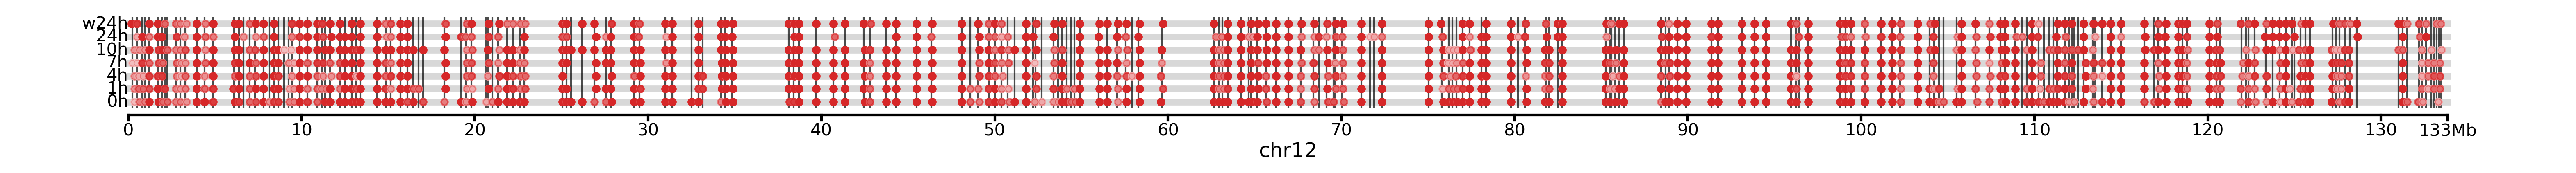

In [162]:
plot_alignment('chr12')

/tmp/ipykernel_128021/580141479.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  col_pos = column[0] // resolution
/tmp/ipykernel_128021/580141479.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = column[n + len(times) + 1] / 10


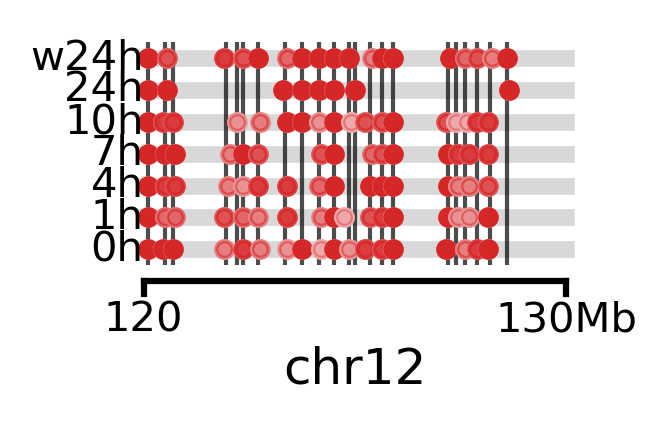

In [163]:
plot_alignment('chr12', 120_000_000, 130_000_000)

/tmp/ipykernel_128021/605297656.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.vlines(column[0] // 50_000, ymin=-0.5, ymax=len(times) - 0.5,
/tmp/ipykernel_128021/605297656.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = column[n + len(times) + 1] / 10


(-133.85, 2810.85, -1.795, 6.895)

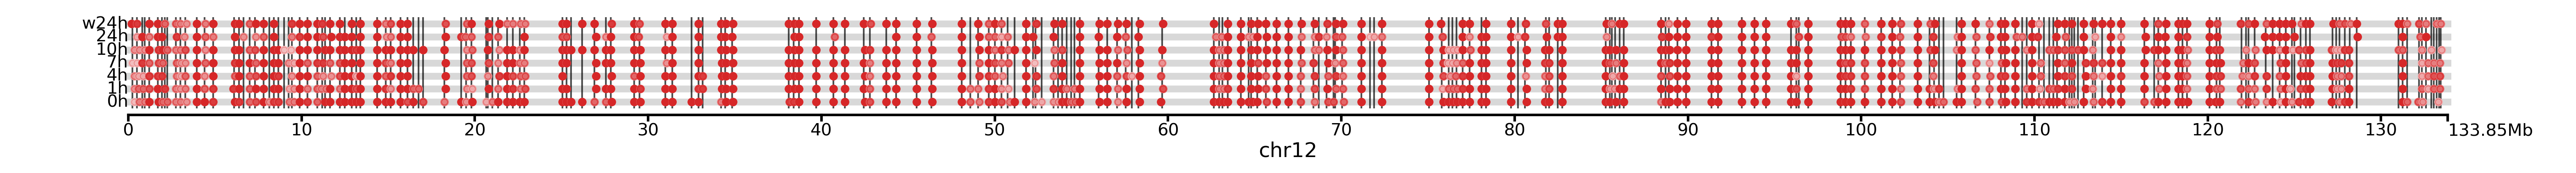

In [164]:
plt.figure(figsize=(chromosomes[chrom] / 5_000_000, 1.2), dpi=300)
for _, column in borders.iterrows():
    for n, border in enumerate(column[1:len(times) + 1]):
        if not n:
            plt.vlines(column[0] // 50_000, ymin=-0.5, ymax=len(times) - 0.5,
                       color='k', alpha=0.7, lw=1, zorder=-1)
        alpha = column[n + len(times) + 1] / 10
        if np.isfinite(alpha):
            plt.plot(border, n, 'o', color='w', alpha=1, ms=4)
        plt.plot(border, n, 'o', color='tab:red', alpha=alpha if np.isfinite(alpha) else 0, ms=4)
for n, t in enumerate(times):
    plt.plot([0, chromosomes[chrom] // 50_000], [n, n], lw=4, color='tab:grey', alpha=0.3, zorder=-10)
    plt.text(0, n, t, ha='right', va='center')
    
plt.plot([0, chromosomes[chrom] // 50_000], [-1, -1], color='k')
for n in list(range(0, chromosomes[chrom] // 50_000, 200)):
    plt.plot([n, n], [-1, -1.4], color='k')
    plt.text(n, -1.6, (n * 50_000) // 1_000_000 ,va='top', ha='center')
n = chromosomes[chrom] // 50_000
plt.plot([n, n], [-1, -1.4], color='k')
plt.text(n, -1.6, f'{(n * 50_000) / 1_000_000}Mb' ,va='top', ha='left')
plt.text(n / 2, -3, chrom, size=12, va='top', ha='center')
plt.axis('off')

# COMPUTE insulation score

In [165]:
from pytadbit.tadbit import insulation_score, insulation_to_borders
from pytadbit import load_hic_data_from_bam

In [166]:
times

['0h', '1h', '4h', '7h', '10h', '24h', 'w24h']

In [72]:
for time in times:
    print(time)
    bam_path = glob(os.path.join(rpath, f'Cabrera_2022_HCT116_WT_*_{time}', 
                                 '03_filtered_reads', 'intersection_*.bam'))
    bias_path = glob(os.path.join(rpath, f'Cabrera_2022_HCT116_WT_*_{time}', 
                                  '04_normalization', 'biases_50kb*'))
    if len(bam_path) != 1:
        raise Exception(bam_path)
    if len(bias_path) != 1:
        raise Exception(bias_path)
    hic_data = load_hic_data_from_bam(bam_path[0], resolution=50_000, ncpus=16, biases=bias_path[0])
    for w0 in range(1, 5):
        for w1 in range(4, 12, 2):
#         for w1 in range(5, 10, 2):
            for d in range(2, 6):
                wsize = (w0, w1)
                insc, delta = insulation_score(hic_data, [wsize], resolution=50000, normalize=True, 
                                               delta=d)
                borders = insulation_to_borders(insc[wsize], delta[wsize], min_strength=0.1)
                out = open(f"insulation-scores/insulation-score_{time}_{wsize[0]}-{wsize[1]}-{d}.pickle", 'wb')
                dump([insc, delta, borders], out, protocol=HIGHEST_PROTOCOL)
                out.close()
                insc.clear()
                delta.clear()
                borders.clear()
    hic_data.clear()

0h

  (Matrix size 61928x61928)                                                    [2023-12-06 00:58:35]

  - Parsing BAM (125 chunks)                                                   [2023-12-06 00:58:35]
     .......... .......... .......... .......... ..........     50/125
     .......... .......... .......... .......... ..........    100/125
     .......... .......... .....                               125/125

  - Getting matrices                                                           [2023-12-06 01:00:29]
     .......... .......... .......... .......... ..........     50/125
     .......... .......... .......... .......... ..........    100/125
     .......... .......... .....                               125/125

 - computing insulation in band 1-4
 - computing insulation in band 1-4
 - computing insulation in band 1-4
 - computing insulation in band 1-4
 - computing insulation in band 1-6
 - computing insulation in band 1-6
 - computing insulation in band 1-6
 - computing

 - computing insulation in band 3-6
 - computing insulation in band 3-6
 - computing insulation in band 3-8
 - computing insulation in band 3-8
 - computing insulation in band 3-8
 - computing insulation in band 3-8
 - computing insulation in band 3-10
 - computing insulation in band 3-10
 - computing insulation in band 3-10
 - computing insulation in band 3-10
 - computing insulation in band 4-4
 - computing insulation in band 4-4
 - computing insulation in band 4-4
 - computing insulation in band 4-4
 - computing insulation in band 4-6
 - computing insulation in band 4-6
 - computing insulation in band 4-6
 - computing insulation in band 4-6
 - computing insulation in band 4-8
 - computing insulation in band 4-8
 - computing insulation in band 4-8
 - computing insulation in band 4-8
 - computing insulation in band 4-10
 - computing insulation in band 4-10
 - computing insulation in band 4-10
 - computing insulation in band 4-10
7h

  (Matrix size 61928x61928)                         

 - computing insulation in band 1-10
 - computing insulation in band 1-10
 - computing insulation in band 1-10
 - computing insulation in band 1-10
 - computing insulation in band 2-4
 - computing insulation in band 2-4
 - computing insulation in band 2-4
 - computing insulation in band 2-4
 - computing insulation in band 2-6
 - computing insulation in band 2-6
 - computing insulation in band 2-6
 - computing insulation in band 2-6
 - computing insulation in band 2-8
 - computing insulation in band 2-8
 - computing insulation in band 2-8
 - computing insulation in band 2-8
 - computing insulation in band 2-10
 - computing insulation in band 2-10
 - computing insulation in band 2-10
 - computing insulation in band 2-10
 - computing insulation in band 3-4
 - computing insulation in band 3-4
 - computing insulation in band 3-4
 - computing insulation in band 3-4
 - computing insulation in band 3-6
 - computing insulation in band 3-6
 - computing insulation in band 3-6
 - computing insulat

# Load insulation scores and corresponding borders after computation

### get bin coordinates

In [18]:
os.path.join(rpath, f'Cabrera_2022_HCT116_WT_NUT_10h',
             '03_filtered_reads', 'intersection_*.bam')

'/home/fransua/Projects/Monica_p53/Hi-C/Cabrera_2022_HCT116_WT_NUT_10h/03_filtered_reads/intersection_*.bam'

In [19]:
hic_data = load_hic_data_from_bam(glob(os.path.join(
    rpath, f'Cabrera_2022_HCT116_WT_NUT_10h',
    '03_filtered_reads', 'intersection_*.bam'))[0], 
                                  resolution=50_000, ncpus=16,
                                  biases=glob(os.path.join(
                                      rpath, f'Cabrera_2022_HCT116_WT_NUT_10h',
                                      '04_normalization', 'biases_50kb*'))[0])
hic_data.clear()

bin2coord = dict((v, k) for k, v in hic_data.sections.items())


  (Matrix size 61928x61928)                                                    [2023-12-06 10:03:30]

  - Parsing BAM (125 chunks)                                                   [2023-12-06 10:03:30]
     .......... .......... .......... .......... ..........     50/125
     .......... .......... .......... .......... ..........    100/125
     .......... .......... .....                               125/125

  - Getting matrices                                                           [2023-12-06 10:06:03]
     .......... .......... .......... .......... ..........     50/125
     .......... .......... .......... .......... ..........    100/125
     .......... .......... .....                               125/125



### get pandas DF from IS

In [20]:
def df_from_insc(borders, insc, delta, time):
    elts = []
    for pos, val in borders:
        i = insc[pos]
        d = delta[pos]
        chrom, pos = bin2coord[pos]
        elts.append([chrom, pos, val, i])
    return pd.DataFrame(data=elts, columns=['Chromosome', f'pos_{time}_IS', 
                                            f'score_{time}_IS',f'density_{time}_IS']
                        # ,                                            f'delta_{cond}_{treat}_IS']
                       ).sort_values(by=f"pos_{time}_IS", ignore_index=True)


## Comparison between replicates

In [61]:
w0 = 1
w1 = 8
d = 2
print(f" window: delta => Median IS-borders   intersection Jaccard Overlap")
for w0 in range(1, 5):
    for w1 in range(5, 10, 2):
        for d in range(2, 6):
            az = []
            bz = []
            cz = []
            jis = []
            ocs = []
            for nt1, (time1) in enumerate(times, 1):
                i1, d1, b1 = load(open(
                    f"insulation-scores/insulation-score_{time1}_{w0}-{w1}-{d}.pickle", 
                    'rb'))
                df1 = df_from_insc(b1, i1[w0, w1], d1[w0, w1], time1)
                for time2 in samples[nt1:]:
                    i2, d2, b2 = load(open(
                        f"insulation-scores/insulation-score_{time2}_{w0}-{w1}-{d}.pickle", 
                        'rb'))
                    df2 = df_from_insc(b2, i2[w0, w1], d2[w0, w1], time2)
                    c, a, b = align_TAD_borders(df1, df2, f'{time1}_IS', f'{time2}_IS')
                    az.append(a)
                    bz.append(b)
                    cz.append(c)
                    nc = c.notna().all(axis=1).sum()
                    jis.append(nc / (a + b - nc))
                    ocs.append(nc / min(a, b))
            print(f"  {w0}-{w1:2} :     {d} =>             {int(np.median(az+bz)):5}          {int(np.median([nc for c in cz])):5} "
                  f"   {np.median(jis):.2f} "
                  f"   {np.median(ocs):.2f}")

 window: delta => Median IS-borders   intersection Jaccard Overlap
  1- 5 :     2 =>              4692           4207    0.80    0.89
  1- 5 :     3 =>              4068           3428    0.75    0.86
  1- 5 :     4 =>              3459           2810    0.71    0.83
  1- 5 :     5 =>              2832           2177    0.64    0.79
  1- 7 :     2 =>              3813           3401    0.78    0.89
  1- 7 :     3 =>              3277           2824    0.74    0.86
  1- 7 :     4 =>              2823           2351    0.68    0.82
  1- 7 :     5 =>              2462           1941    0.64    0.79
  1- 9 :     2 =>              3304           2922    0.75    0.88
  1- 9 :     3 =>              2765           2321    0.70    0.84
  1- 9 :     4 =>              2343           1893    0.66    0.80
  1- 9 :     5 =>              2039           1554    0.60    0.76
  2- 5 :     2 =>              4712           4139    0.77    0.87
  2- 5 :     3 =>              4188           3469    0.74    

## Comparison with TADbit

In [62]:
w0 = 1
w1 = 8
d = 2
print(f" window: delta => Median IS-borders Median TADbit-borders intersection Jaccard Overlap")
for w0 in range(1, 5):
    for w1 in range(5, 10, 2):
        for d in range(2, 6):
            az = []
            bz = []
            cz = []
            jis = []
            ocs = []
            for nt1, (time1) in enumerate(times, 1):
                i1, d1, b1 = load(open(f"insulation-scores/insulation-score_{time1}_{w0}-{w1}-{d}.pickle", 'rb'))
                df1 = df_from_insc(b1, i1[w0, w1], d1[w0, w1], time1)
                df2 = tads[time1]
                c, a, b = align_TAD_borders(df1, df2, f'{time1}_IS', f'{time1}')
                az.append(a)
                bz.append(b)
                cz.append(c)
                nc = c.notna().all(axis=1).sum()
                jis.append(nc / (a + b - nc))
                ocs.append(nc / min(a, b))
            print(f"  {w0}-{w1:2} :     {d} =>             {int(np.median(az)):5}                 {int(np.median(bz)):5}        {int(np.median([nc for c in cz])):5} "
                  f"   {np.median(jis):.2f} "
                  f"   {np.median(ocs):.2f}")

 window: delta => Median IS-borders Median TADbit-borders intersection Jaccard Overlap
  1- 5 :     2 =>              4692                  3266         2653    0.53    0.82
  1- 5 :     3 =>              4068                  3266         2364    0.50    0.73
  1- 5 :     4 =>              3459                  3266         2113    0.48    0.67
  1- 5 :     5 =>              2832                  3266         1813    0.44    0.67
  1- 7 :     2 =>              3813                  3266         2477    0.56    0.76
  1- 7 :     3 =>              3277                  3266         2178    0.51    0.70
  1- 7 :     4 =>              2823                  3266         1934    0.47    0.70
  1- 7 :     5 =>              2462                  3266         1702    0.43    0.72
  1- 9 :     2 =>              3304                  3266         2336    0.56    0.74
  1- 9 :     3 =>              2765                  3266         1972    0.50    0.74
  1- 9 :     4 =>              2343        

# BEST SOLUTION for Insulation Score

window from -1 to -8 and +1 to +8 -> a square of 350kb side 50 kb above matrix diagonal

## store borders and IS

In [21]:
w0 = 1
w1 = 8
d = 2

In [22]:
def hola(x):
    return i1.get(tuple(x.to_list()))

In [25]:
insulations = {}
for t in times:
    i1, d1, b1 = load(open(f"insulation-scores/insulation-score_{t}_1-8-2.pickle", 'rb'))
    i1 = dict((bin2coord[i], v) for i, v in i1[w0, w1].items())
    insulations[t] = i1
    aligned_tads[f'IS_{t}'] = aligned_tads[['Chromosome', f'pos_{t}']].apply(hola, axis=1)

In [32]:
IS = pd.DataFrame()
IS["Chromosome"] = [c for c in chromosomes for pos in range(0, chromosomes[c] // 50_000 + 1)]
IS["Start"] = [pos * 50_000 for c in chromosomes for pos in range(0, chromosomes[c] // 50_000 + 1)]
IS["End"] = [pos * 50_000 + 1 for c in chromosomes for pos in range(0, chromosomes[c] // 50_000 + 1)]
for t in times:
    IS[t] = [insulations[t].get((c, pos), float('nan')) 
             for c in chromosomes 
             for pos in range(0, chromosomes[c] // 50_000 + 1)]
            

In [33]:
IS.head(10000)

,Chromosome,Start,End,0h,1h,4h,7h,10h,24h,w24h,w48h
0,chr1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,50000,50001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,100000,100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,150000,150001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,200000,200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9995,chr3,7250000,7250001,-0.195839,-0.201345,-0.207928,-0.153889,-0.327465,0.019734,-0.134784,-0.495034
9996,chr3,7300000,7300001,-0.178229,-0.159097,-0.133005,-0.118833,-0.283641,0.098779,-0.051154,-0.375398
9997,chr3,7350000,7350001,-0.091872,-0.064271,-0.041410,-0.058516,-0.193485,0.240592,0.034181,-0.147307
9998,chr3,7400000,7400001,-0.082093,-0.011683,0.007706,-0.009009,-0.116971,0.289016,0.084819,-0.082245


In [34]:
IS.to_csv(f"genomic-Insulation-Score_1-8-2.tsv", sep="\t")

In [36]:
aligned_tads = aligned_tads[['Chromosome', 'position',
                             'pos_0h'  , 'score_0h'  , 'density_0h'  , 'IS_0h'  ,
                             'pos_1h'  , 'score_1h'  , 'density_1h'  , 'IS_1h'  ,
                             'pos_4h'  , 'score_4h'  , 'density_4h'  , 'IS_4h'  ,
                             'pos_7h'  , 'score_7h'  , 'density_7h'  , 'IS_7h'  ,
                             'pos_10h' , 'score_10h' , 'density_10h' , 'IS_10h' ,
                             'pos_24h' , 'score_24h' , 'density_24h' , 'IS_24h' ,
                             'pos_w24h', 'score_w24h', 'density_w24h', 'IS_w24h',
                             'pos_w48h', 'score_w48h', 'density_w48h', 'IS_w48h',
                            ]]

In [37]:
aligned_tads

,Chromosome,position,pos_0h,score_0h,density_0h,IS_0h,pos_1h,score_1h,density_1h,IS_1h,...,density_24h,IS_24h,pos_w24h,score_w24h,density_w24h,IS_w24h,pos_w48h,score_w48h,density_w48h,IS_w48h
0,chr5,150000,3.0,5.0,1.469,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr7,198437,5.0,7.0,0.938,NaN,4.0,7.0,0.600,NaN,...,NaN,NaN,4.0,7.0,3.851,NaN,4.0,4.0,1.224,NaN
2,chr2,200000,3.0,10.0,1.479,NaN,3.0,10.0,1.497,NaN,...,1.582,NaN,3.0,7.0,1.345,NaN,5.0,3.0,1.205,NaN
3,chr12,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,10.0,0.109,NaN,NaN,NaN,NaN,NaN
4,chr10,237890,4.0,5.0,0.926,NaN,5.0,6.0,0.882,NaN,...,0.294,NaN,4.0,9.0,0.884,NaN,5.0,3.0,0.820,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957,chr1,248000000,4960.0,3.0,0.989,0.763898,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4958,chr1,248137500,4965.0,3.0,0.948,1.158776,4963.0,5.0,0.934,1.088557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4959,chr1,248550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4971.0,8.0,1.127,0.345336
4960,chr1,248662500,4974.0,6.0,0.963,0.166740,4974.0,6.0,0.932,0.153004,...,1.149,0.233957,4973.0,10.0,1.277,0.737918,NaN,NaN,NaN,NaN


In [39]:
aligned_tads.columns

Index(['Chromosome', 'position', 'pos_0h', 'score_0h', 'density_0h', 'IS_0h',
       'pos_1h', 'score_1h', 'density_1h', 'IS_1h', 'pos_4h', 'score_4h',
       'density_4h', 'IS_4h', 'pos_7h', 'score_7h', 'density_7h', 'IS_7h',
       'pos_10h', 'score_10h', 'density_10h', 'IS_10h', 'pos_24h', 'score_24h',
       'density_24h', 'IS_24h', 'pos_w24h', 'score_w24h', 'density_w24h',
       'IS_w24h', 'pos_w48h', 'score_w48h', 'density_w48h', 'IS_w48h'],
      dtype='object')

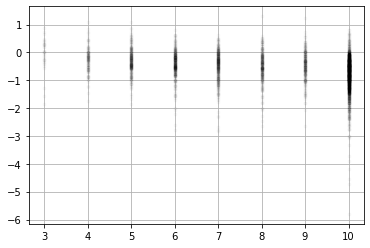

In [40]:
plt.plot(aligned_tads['score_1h'], aligned_tads['IS_1h'], 'k.', alpha=0.02)
plt.grid()

In [41]:
import seaborn as sb
from scipy import stats

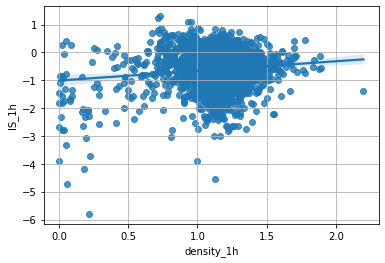

In [42]:
#tdata = aligned_tads[~np.isnan(aligned_tads[['density_1h', 'IS_1h']])][['density_1h', 'IS_1h']]
tdata = aligned_tads[['density_1h', 'IS_1h']].replace([np.inf, -np.inf], np.nan)
tdata.dropna(how="all", inplace=True)

sb.regplot(data=tdata, x = 'density_1h', y = 'IS_1h')
plt.grid()

In [43]:
tdata.dropna(how="any", inplace=True, axis=0)

In [44]:
max(tdata['IS_1h'])

1.2969821369466774

In [45]:
tdata['exp_IS_1h'] = 1 / (1 + np.exp(tdata['IS_1h']))

In [46]:
max(tdata['exp_IS_1h'])

0.9969788432194829

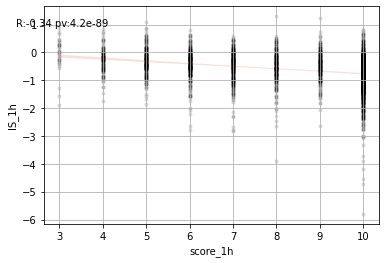

In [48]:
tdata = aligned_tads[['score_1h', 'IS_1h']].replace([np.inf, -np.inf], np.nan)
tdata.dropna(how="any", inplace=True)

# tdata['IS_1h'] = 1 / (1 + np.exp(tdata['IS_1h']))

r, pv = stats.spearmanr(tdata['score_1h'], tdata['IS_1h'])

sb.regplot(data=tdata, x = 'score_1h', y = 'IS_1h', color='k', 
           scatter_kws={'alpha':0.1, 's': 10},
           line_kws={'color': 'tab:red', 'alpha':1})

# r, pv =  stats.pearsonr(tdata['score_1h'], tdata['IS_1h'])
plt.text(2, 0.93, (f'R:{r:.2} pv:{pv:.1e}'))
plt.grid()


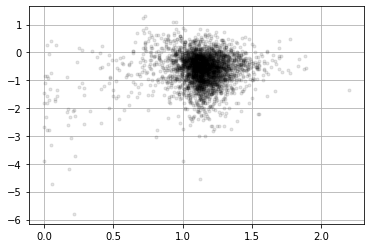

In [49]:
plt.plot(aligned_tads['density_1h'], aligned_tads['IS_1h'], 'k.', alpha=0.1)
plt.grid()

In [50]:
aligned_tads[(aligned_tads['Chromosome']=='chr12') & (aligned_tads['position'] > 70_000_000)]

,Chromosome,position,pos_0h,score_0h,density_0h,IS_0h,pos_1h,score_1h,density_1h,IS_1h,...,density_24h,IS_24h,pos_w24h,score_w24h,density_w24h,IS_w24h,pos_w48h,score_w48h,density_w48h,IS_w48h
2530,chr12,70069140,1403.0,7.0,1.088,-0.754341,1402.0,7.0,1.174,-0.744430,...,0.775,-1.006820,1402.0,10.0,1.143,-0.711159,1401.0,3.0,1.363,-0.495923
2575,chr12,71150000,1423.0,10.0,1.105,-0.441493,1423.0,10.0,1.112,-0.327189,...,1.141,-0.049287,1423.0,10.0,0.869,-0.646397,1423.0,7.0,0.896,-0.584298
2585,chr12,71500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1430.0,5.0,0.723,-0.292122
2593,chr12,71650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.951,0.229862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2599,chr12,71900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.824,0.211473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,chr12,132900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4104,chr12,133050000,NaN,NaN,NaN,NaN,2661.0,7.0,0.943,-0.359421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4108,chr12,133200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2664.0,6.0,3.675,0.077964,NaN,NaN,NaN,NaN
4112,chr12,133393750,2666.0,4.0,0.284,-2.701856,2668.0,7.0,0.786,-1.381117,...,NaN,NaN,NaN,NaN,NaN,NaN,2668.0,5.0,0.662,-1.068677


### transform all Insulation Scores

In [51]:
for t in times:
    aligned_tads[f'IS_{t}'] = 1 / (1 + np.exp(aligned_tads[f'IS_{t}']))

In [52]:
aligned_tads[(aligned_tads['Chromosome']=='chr12') & (aligned_tads['position'] > 70_000_000)]

,Chromosome,position,pos_0h,score_0h,density_0h,IS_0h,pos_1h,score_1h,density_1h,IS_1h,...,density_24h,IS_24h,pos_w24h,score_w24h,density_w24h,IS_w24h,pos_w48h,score_w48h,density_w48h,IS_w48h
2530,chr12,70069140,1403.0,7.0,1.088,0.680124,1402.0,7.0,1.174,0.677964,...,0.775,0.732397,1402.0,10.0,1.143,0.670657,1401.0,3.0,1.363,0.621501
2575,chr12,71150000,1423.0,10.0,1.105,0.608615,1423.0,10.0,1.112,0.581075,...,1.141,0.512319,1423.0,10.0,0.869,0.656198,1423.0,7.0,0.896,0.642056
2585,chr12,71500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1430.0,5.0,0.723,0.572516
2593,chr12,71650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.951,0.442786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2599,chr12,71900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.824,0.447328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,chr12,132900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4104,chr12,133050000,NaN,NaN,NaN,NaN,2661.0,7.0,0.943,0.588900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4108,chr12,133200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2664.0,6.0,3.675,0.480519,NaN,NaN,NaN,NaN
4112,chr12,133393750,2666.0,4.0,0.284,0.937136,2668.0,7.0,0.786,0.799170,...,NaN,NaN,NaN,NaN,NaN,NaN,2668.0,5.0,0.662,0.744345


In [53]:
aligned_tads.to_csv('aligned_TADbit_TAD-borders.tsv', sep='\t', index=False)

## Align all IS TAD-borders

In [55]:
dist_cut = 2
score_cut = 2
time1 = times[0]
i1, d1, b1 = load(open(f"insulation-scores/insulation-score_{time1}_1-8-2.pickle", 'rb'))
aligned_tads = df_from_insc(b1, i1[w0, w1], d1[w0, w1], time1)
aligned_tads['pos_global'] = aligned_tads['pos_0h_IS'].copy()

for nt2, (time2) in enumerate(times[1:], 1):
    print(time2)
    i1, d1, b1 = load(open(f"insulation-scores/insulation-score_{time2}_1-8-2.pickle", 'rb'))
    
    aligned_tads, a, b = align_TAD_borders(aligned_tads, 
                                           df_from_insc(b1, i1[w0, w1], d1[w0, w1], 
                                                        time2), 
                                           'global', f'{time2}_IS')

1h
4h
7h
10h
24h
w24h
w48h


In [56]:
aligned_tads

,Chromosome,pos_0h_IS,score_0h_IS,density_0h_IS,pos_global,pos_1h_IS,score_1h_IS,density_1h_IS,pos_4h_IS,score_4h_IS,...,density_10h_IS,pos_24h_IS,score_24h_IS,density_24h_IS,pos_w24h_IS,score_w24h_IS,density_w24h_IS,pos_w48h_IS,score_w48h_IS,density_w48h_IS
0,chr19,NaN,NaN,NaN,10.0,NaN,NaN,NaN,10.0,0.143847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr11,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr17,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,11.0,0.66363,-2.598578,NaN,NaN,NaN,NaN,NaN,NaN
3,chr4,12,0.504538,-1.513951,11.859375,13.0,0.619691,-1.063962,13.0,0.703289,...,-2.317785,NaN,NaN,NaN,11.0,0.419091,0.032614,12.0,0.706105,-1.565778
4,chr5,13,0.281841,-0.381212,12.9375,13.0,0.276996,-0.126475,13.0,0.129146,...,-0.383192,13.0,0.650706,-4.24795,NaN,NaN,NaN,13.0,0.267933,0.848678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,chr1,NaN,NaN,NaN,4922.25,4922.0,0.339195,0.285213,4922.0,0.32427,...,0.261592,4922.0,0.441367,0.288218,4923.0,0.326356,0.075705,4922.0,0.393619,0.171283
4946,chr1,4938,0.508581,-0.668532,4938.65625,4938.0,0.602314,-0.900656,4938.0,0.619264,...,-0.926342,4939.0,0.698258,-1.044597,4938.0,0.389718,-0.600116,4939.0,0.511043,-0.861105
4947,chr1,4950,0.563413,-0.567839,4949.71875,4950.0,0.33109,-0.339278,4950.0,0.296039,...,-0.438664,4948.0,0.210166,0.049793,4950.0,0.551995,-0.311104,4950.0,0.419478,-0.567729
4948,chr1,NaN,NaN,NaN,4953.0,NaN,NaN,NaN,NaN,NaN,...,NaN,4953.0,0.336804,-0.006465,NaN,NaN,NaN,NaN,NaN,NaN


### some renaming

In [57]:
for t in times:
    aligned_tads.rename(columns={f'score_{t}_IS': f'strength_{t}'}, inplace=True)
    aligned_tads.rename(columns={f'density_{t}_IS': f'IS_{t}'}, inplace=True)
    aligned_tads.rename(columns={f'pos_{t}_IS': f'pos_{t}'}, inplace=True)

### sigmoid transform of IS

In [58]:
for t in times:
    aligned_tads[f'IS_{t}'] = aligned_tads[f'IS_{t}'].astype(float)
    aligned_tads[f'IS_{t}'] = 1 / (1 + np.exp(aligned_tads[f'IS_{t}']))

In [59]:
aligned_tads

,Chromosome,pos_0h,strength_0h,IS_0h,pos_global,pos_1h,strength_1h,IS_1h,pos_4h,strength_4h,...,IS_10h,pos_24h,strength_24h,IS_24h,pos_w24h,strength_w24h,IS_w24h,pos_w48h,strength_w48h,IS_w48h
0,chr19,NaN,NaN,NaN,10.0,NaN,NaN,NaN,10.0,0.143847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr11,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr17,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,11.0,0.66363,0.930770,NaN,NaN,NaN,NaN,NaN,NaN
3,chr4,12,0.504538,0.819646,11.859375,13.0,0.619691,0.743447,13.0,0.703289,...,0.910339,NaN,NaN,NaN,11.0,0.419091,0.491847,12.0,0.706105,0.827181
4,chr5,13,0.281841,0.594165,12.9375,13.0,0.276996,0.531577,13.0,0.129146,...,0.594643,13.0,0.650706,0.985908,NaN,NaN,NaN,13.0,0.267933,0.299710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,chr1,NaN,NaN,NaN,4922.25,4922.0,0.339195,0.429176,4922.0,0.32427,...,0.434972,4922.0,0.441367,0.428440,4923.0,0.326356,0.481083,4922.0,0.393619,0.457284
4946,chr1,4938,0.508581,0.661174,4938.65625,4938.0,0.602314,0.711084,4938.0,0.619264,...,0.716332,4939.0,0.698258,0.739736,4938.0,0.389718,0.645683,4939.0,0.511043,0.702891
4947,chr1,4950,0.563413,0.638264,4949.71875,4950.0,0.33109,0.584015,4950.0,0.296039,...,0.607941,4948.0,0.210166,0.487554,4950.0,0.551995,0.577155,4950.0,0.419478,0.638239
4948,chr1,NaN,NaN,NaN,4953.0,NaN,NaN,NaN,NaN,NaN,...,NaN,4953.0,0.336804,0.501616,NaN,NaN,NaN,NaN,NaN,NaN


### save IS TAD borders

In [60]:
aligned_tads.to_csv('aligned_IS_TAD-borders.tsv', sep='\t', index=False)

## Align to TADbit borders

In [215]:
w0 = 1
w1 = 8
d = 2

az = []
bz = []
cz = []
all_tads = []
jis = []
ocs = []
for nt1, time1 in enumerate(times, 1):
    i1, d1, b1 = load(open(f"insulation-scores/insulation-score_{time1}_{w0}-{w1}-{d}.pickle", 'rb'))
    df1 = df_from_insc(b1, i1[w0, w1], d1[w0, w1], time1)
    df2 = tads[time1]
    all_tads.append(df1)
    all_tads.append(df2)
    c, a, b = align_TAD_borders(df1, df2, f'{time1}_IS', f'{time1}', score_cut=0)
    az.append(a)
    bz.append(b)
    cz.append(c)
    nc = c.notna().all(axis=1).sum()
    jis.append(nc / (a + b - nc))
    ocs.append(nc / min(a, b))
#     print(f"{time1:3}      {int(a):5}                 {int(b):5}        {int(nc):5} "
#           f"   {nc / (a + b - nc):.2f} "
#           f"   {nc / min(a, b):.2f}")    
    print(f"{time1}\t{int(a)}\t{int(b)}\t{int(nc)}\t"
          f"{nc / (a + b - nc):.2f}\t"
          f"{nc / min(a, b):.2f}")    
print(f"  {w0}-{w1:2} :     {d} =>             {int(np.median(az)):5}                 {int(np.median(bz)):5}        {int(np.median([nc for c in cz])):5} "
      f"   {np.median(jis):.2f} "
      f"   {np.median(ocs):.2f}")

0h	3652	4155	2762	0.55	0.76
1h	3477	3355	2477	0.57	0.74
4h	3520	3242	2455	0.57	0.76
7h	3520	3189	2400	0.56	0.75
10h	3628	3576	2550	0.55	0.71
24h	3434	2965	2088	0.48	0.70
  1- 8 :     2 =>              3520                  3298         2088    0.55    0.75
